In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os

In [ ]:
# because i hate how np.append works

def numpy_append(a, b):
    EMPTY_SHAPE = (0,)

    shape = np.shape(a)
    # catch case of adding the first element to the array
    if shape == EMPTY_SHAPE:
        shape = (0, *np.shape(b))

    new_shape = (shape[0]+1, *shape[1:])
    a = np.append(a, b)
    a = np.reshape(a, new_shape)

    return a

#### TODO:

- add function for converting between pixels to mm (for spot width)

# Chromox Screens for transverse instabilities

# loading data - can ignore bc code will already have this

In [4]:
folder = "example_data"
filenames = os.listdir(folder)

In [5]:
HRM3_filenames = [filename for filename in filenames if "HRM3" in filename]
HRM4_filenames = [filename for filename in filenames if "HRM4" in filename]

In [7]:
def load_DigiCam_image(folder, filename):
    """
    works for the files that start with:
    'BG_HRM3.DigiCam...' & 'HRM3.DigiCam...'
    'BG_HRM4.DigiCam...' & 'HRM4.DigiCam...'
    'HRM5.DigiCam...'
    'HRM6.DigiCam...'
    """

    # first column and row is coordinate data, which is removed
    image = np.loadtxt(f"{folder}/{filename}", delimiter=",", skiprows=1)
    image = np.delete(image, 0, axis=1)
    return image

# Data Processing

### 1. Background Subtraction - not done

- subtract darkfield images
- subtract no beam and no plasma images

### 2. Analysis

- lineouts
- standard deviation of Gaussian fit to determine spot width

In [58]:
def perform_image_lineouts(image, axis=0):

    # create an array of x values to go with the linspace, for fitting and plotting
    # final argument is 1 x_val [pixels], should modify for x_val [mm]
    if axis == 0:
        ls = np.arange(0, len(image[0]), 1)
    else:
        ls = np.arange(0, len(image[:,0]), 1)


    return ls, np.sum(image, axis=axis)


In [ ]:
def Gaussian_plus_flat_background(x,peak,mu,sigma, offset):
    return peak*np.exp(-(x-mu)**2/(2*sigma**2)) + offset

In [35]:
def fit_Gaussian_plus_flat_background(lineout_ls, lineout_vals):
    """
    takes x_vals of the lineout (probably an np.linsapce), and the lineout values
    """

    # dont have a good way of estimating the standard deviation in the inital guess
    # initial guess = [peak, mu, sigma, offset in y]
    initial_guess = [np.max(lineout_vals), np.argmax(lineout_vals), 20, np.mean(lineout_vals)]
    cfit = curve_fit(Gaussian_plus_flat_background, lineout_ls, lineout_vals, p0 = initial_guess)
    return cfit[0]


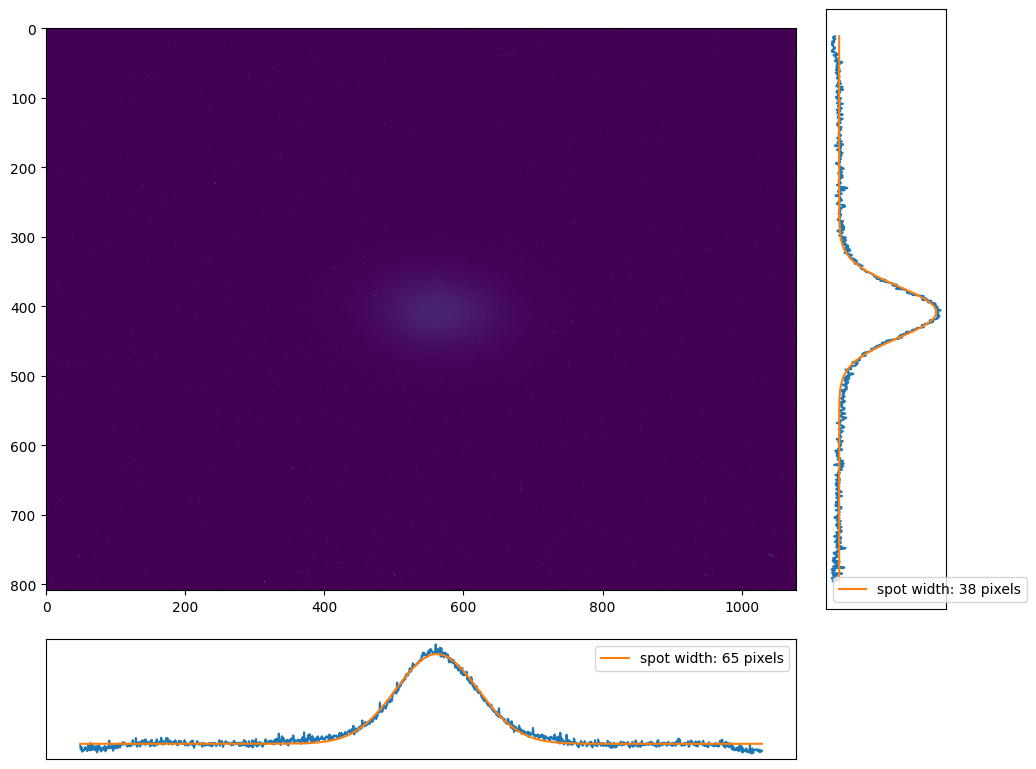

In [ ]:
# load image (these are all the HRM3/4 i have downloaded that have a spot)
# image = load_DigiCam_image(folder, HRM3_filenames[1])
# image = load_DigiCam_image(folder, HRM3_filenames[3])
image = load_DigiCam_image(folder, HRM4_filenames[0])
# image = load_DigiCam_image(folder, HRM4_filenames[1])


# get lineouts and linspaces for use in fitting and to plotting
hor_xs, lineout_x = perform_image_lineouts(image, axis=0)
vert_xs, lineout_y = perform_image_lineouts(image, axis=1)


# fit gaussian to find spot width
x_cfit = fit_Gaussian_plus_flat_background(hor_xs, lineout_x)
y_cfit = fit_Gaussian_plus_flat_background(vert_xs, lineout_y)

spot_size = [x_cfit[2], y_cfit[2]]



# =========================================================
# plotting

fig = plt.figure(figsize=(15,15))

# adding subplots to the correct places
# rect = [left, bottom, width, height]
ax1 = fig.add_axes(rect=[0., 0.05, 0.5, 0.5])
ax2 = fig.add_axes(rect=[0., 0., 0.5, 0.08])
# ax2.axis("off")
ax3 = fig.add_axes(rect=[0.52, 0.1, 0.08, 0.4])
# ax3.axis("off")

ax1.imshow(image)

# plot the lineouts
ax2.plot(hor_xs, lineout_x)
ax2.plot(hor_xs, Gaussian_plus_flat_background(hor_xs, *x_cfit), label=f"spot width: {spot_size[0]:.0f} pixels")
ax3.plot(lineout_y[::-1], vert_xs)
ax3.plot(Gaussian_plus_flat_background(vert_xs[::-1], *y_cfit), vert_xs, label=f"spot width: {spot_size[1]:.0f} pixels")

# remove axes from the linouts bc they messy
ax2.set_xticks([]); ax2.set_xticklabels([]); ax2.set_yticks([]); ax2.set_yticklabels([])
ax3.set_xticks([]); ax3.set_xticklabels([]); ax3.set_yticks([]); ax3.set_yticklabels([])

ax2.legend(); ax3.legend()

plt.show()

# Data Plotting

- show raw image - already done in the code
- show lineouts (mean and error from average over ~5 shots), with standard deviation of spots in x and y

- plot std of centroid - idk what this means

In [ ]:
# AVERAGING LINEOUTS OVER MULTIPLE SHOTS, NEXT CELL DOES THE PLOTTING

# for now shots is just the index of the shot in my array of filenames
shots = [3,3,3]

all_lineouts_x = np.array([])
all_lineouts_y = np.array([])

spot_sizes = np.array([])

for shot in shots:

    # load image
    image = load_DigiCam_image(folder, HRM3_filenames[shot])

    # perform lineouts (and create the corresponding linspaces)
    hor_xs, lineout_x = perform_image_lineouts(image, axis=0)
    vert_xs, lineout_y = perform_image_lineouts(image, axis=1)

    # add some randomness to lineouts so im not averaging over the same thing
    # =================================================================
    # REMOVE
    # =================================================================
    lineout_x += np.random.randint(-100, 100, size=len(lineout_x))*100
    lineout_y += np.random.randint(-100, 100, size=len(lineout_y))*100
    # =================================================================
    # REMOVE
    # =================================================================

    all_lineouts_x = numpy_append(all_lineouts_x, lineout_x)
    all_lineouts_y = numpy_append(all_lineouts_y, lineout_y)

    # perform fitting in order to calculate spot size
    x_cfit = fit_Gaussian_plus_flat_background(hor_xs, lineout_x)
    y_cfit = fit_Gaussian_plus_flat_background(vert_xs, lineout_y)

    spot_sizes = numpy_append(spot_sizes, [x_cfit[2], y_cfit[2]])

[20.85639278 18.62002905] [0.37302017 0.22395702]


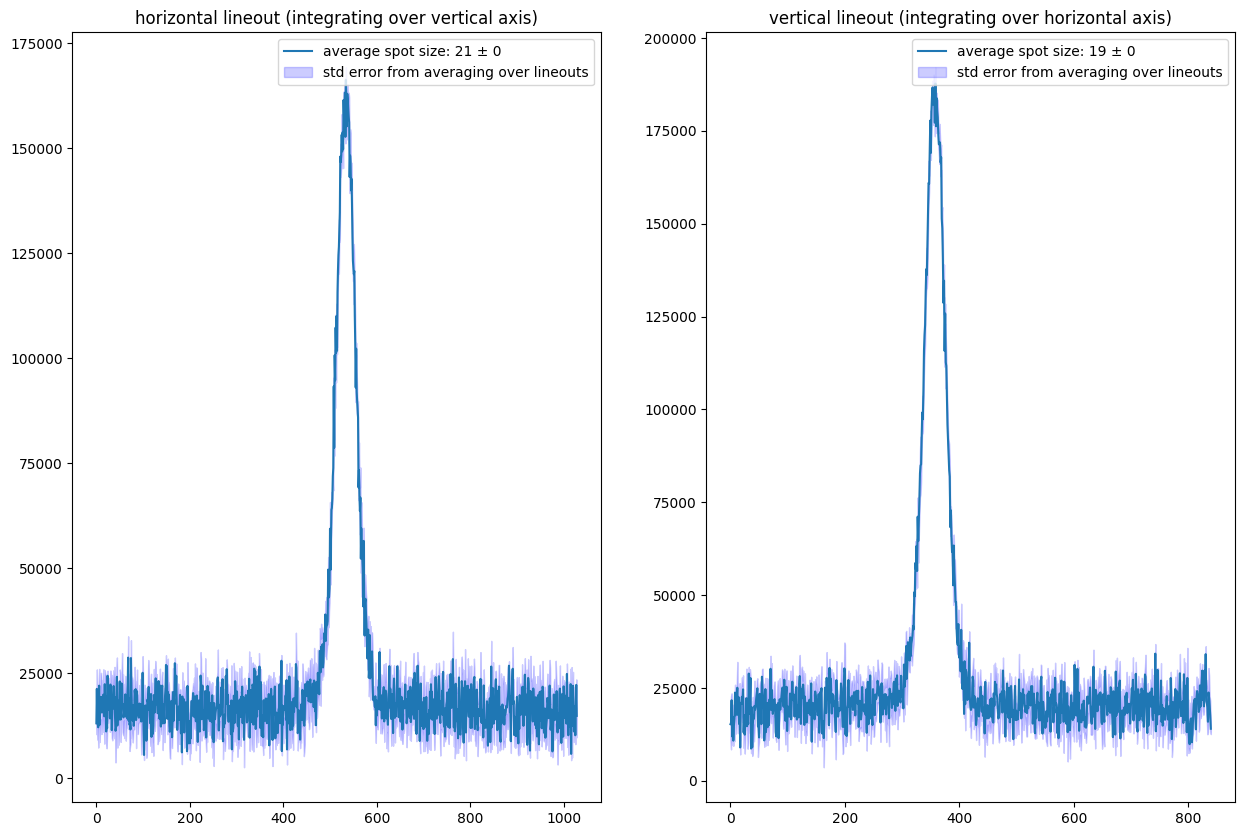

In [122]:
fig,axs = plt.subplots(1,2, figsize=(15,10))
axs[0].set_title("horizontal lineout (integrating over vertical axis)")
axs[1].set_title("vertical lineout (integrating over horizontal axis)")

avg_lineout_x = np.mean(all_lineouts_x, axis=0)
avg_lineout_y = np.mean(all_lineouts_y, axis=0)
std_lineout_x = np.std(all_lineouts_x, axis=0)
std_lineout_y = np.std(all_lineouts_y, axis=0)

avg_spot_size = np.mean(spot_sizes, axis=0)
std_spot_size = np.std(spot_sizes, axis=0)

print(avg_spot_size, std_spot_size)

axs[0].plot(hor_xs, avg_lineout_x, label=f"average spot size: {avg_spot_size[0]:.0f} ± {std_spot_size[0]:.0f}")
axs[1].plot(vert_xs, avg_lineout_y, label=f"average spot size: {avg_spot_size[1]:.0f} ± {std_spot_size[1]:.0f}")

axs[0].fill_between(hor_xs, avg_lineout_x - std_lineout_x, avg_lineout_x + std_lineout_x, color='blue', alpha=0.2, label="std error from averaging over lineouts")
axs[1].fill_between(vert_xs, avg_lineout_y - std_lineout_y, avg_lineout_y + std_lineout_y, color='blue', alpha=0.2, label="std error from averaging over lineouts")



axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
plt.show()